IMPORTS

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import json
# import matplotlib.pyplot as plt
# import segmentation_models as sm

In [3]:
#Segmentation model backend set 
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [4]:
# import keras
# import sys
# print(sys.executable)
# !pip list
# from tensorflow.keras import layers

Data Loading

In [5]:
train_data_dir = r"C:\Users\manup\Downloads\crop_dataset\train"
valid_data_dir = r"C:\Users\manup\Downloads\crop_dataset\valid"
test_data_dir = r"C:\Users\manup\Downloads\crop_dataset\tes"

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir
)

Found 70295 files belonging to 38 classes.


In [7]:
valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_data_dir
)

Found 17572 files belonging to 38 classes.


In [8]:
print("Class names:", train_data.class_names)
# print("Class names:/n/n", valid_data.class_names)


Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomat

In [9]:
for images, labels in train_data.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)


Images batch shape: (32, 256, 256, 3)
Labels batch shape: (32,)


U-Net Model 

In [10]:
#enocder block
def encoder_block(input, num_filters):

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    
    return x,p

In [11]:
#decoder block
def decoder_block(input, skip_tensor, filters):
    # Upsample
    x = tf.keras.layers.UpSampling2D((2, 2))(input)
    
    # First convolution after upsampling
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Concatenate skip connection
    x = tf.keras.layers.concatenate([x, skip_tensor])
    
    # Two consecutive conv layers
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [12]:
def unet(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(p4)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)
    
    # Expansive Path (Decoder)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

Training

In [15]:
import glob 
seg_data = "C:/Users/manup/Desktop/capstone/code/segmentation_data"
os.listdir(seg_data)

images_paths = glob.glob( f'{os.path.join(seg_data, "images")}/*.*')
masks_paths = glob.glob( f'{os.path.join(seg_data, "masks")}/*.*')

images_paths = sorted(images_paths)
masks_paths = sorted(masks_paths)

Segmentation image Preprocessing

In [ ]:
# IMG_HEIGHT = 256
# IMG_WIDTH = 256
# IMG_CHANNELS = 3

# X = []
# Y = []

# for img_path, mask_path in zip(images_paths, masks_paths):
#     img = cv2.imread(img_path)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
#     img = img / 255.0  # normalize to [0,1]
    
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
#     mask = mask / 255.0  # normalize to [0,1]
#     mask = np.expand_dims(mask, axis=-1)  # shape (H, W, 1)
    
#     X.append(img)
#     Y.append(mask)

# X = np.array(X, dtype=np.float32)
# Y = np.array(Y, dtype=np.float32)

In [19]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
batch_size = 32

def process_path(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # grayscale mask
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = mask / 255.0

    return img, mask

dataset = tf.data.Dataset.from_tensor_slices((images_paths, masks_paths))
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [39]:
import numpy as np

X = []
Y = []

for images, masks in dataset:
    X.append(images.numpy())
    Y.append(masks.numpy())

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

print(X.shape, Y.shape)  # now you have full numpy arrays of inputs and labels


(2940, 256, 256, 3) (2940, 256, 256, 1)


In [40]:
print(X.shape, Y.shape)
# print(X[0])
# print(Y)

(2940, 256, 256, 3) (2940, 256, 256, 1)


In [ ]:
# import matplotlib.pyplot as plt

# # Take one batch from the dataset
# for images, masks in dataset.take(1):
#     # images.shape = (batch_size, H, W, C)
#     # masks.shape = (batch_size, H, W, 1)
#     print(images.shape, masks.shape)
    
#     # Plot first few images and masks in the batch
#     for i in range(min(4, images.shape[0])):  # show up to 4 samples
#         plt.subplot(4, 2, 2*i + 1)
#         plt.imshow(images[i].numpy())
#         plt.title("Image")
#         plt.axis("off")

#         plt.subplot(4, 2, 2*i + 2)
#         plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
#         plt.title("Mask")
#         plt.axis("off")
#     plt.show()
#     break  # only do one batch


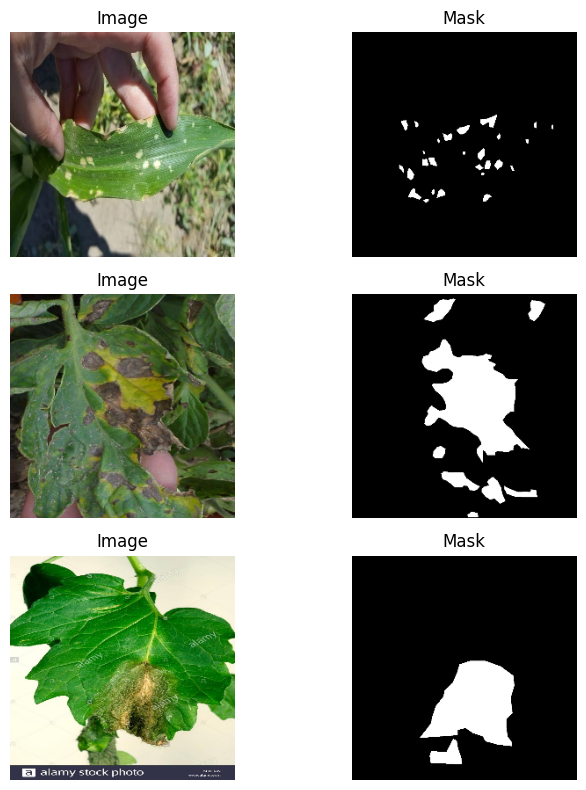

In [43]:
import matplotlib.pyplot as plt
import random

num_samples = 3
indices = random.sample(range(len(X)), num_samples)

plt.figure(figsize=(8, 8))

for i, idx in enumerate(indices):
    # Original image
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(X[idx])
    plt.title("Image")
    plt.axis('off')
    
    # Corresponding mask
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(Y[idx], cmap='gray')
    plt.title("Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.2, random_state=42
)


In [17]:
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {Y_train.shape}")
print("-" * 30)
print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {Y_val.shape}")
print("-" * 30)
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {Y_test.shape}")

Training images shape: (1881, 256, 256, 3)
Training masks shape: (1881, 256, 256, 1)
------------------------------
Validation images shape: (471, 256, 256, 3)
Validation masks shape: (471, 256, 256, 1)
------------------------------
Test images shape: (588, 256, 256, 3)
Test masks shape: (588, 256, 256, 1)


Accuracy and Loss Metrics

In [18]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [19]:
unet_model = unet()
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 34,540,737 (131.76 MB)

 Trainable params: 34,527,041 (131.71 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [20]:
unet_model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coefficient, iou_metric, 'accuracy']
)


In [21]:
#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_dir = 'C:/Users/manup/Desktop/capstone/segmentation_model'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(checkpoint_dir, 'best_segmentation_model.h5'),
    monitor = 'val_dice_coefficient',  
    save_best_only = True,         
    save_weights_only = False,      
    mode = 'max',                  
    verbose = 1)

early_stopping = EarlyStopping(
    monitor = 'val_dice_coefficient',
    min_delta = 0.001,
    patience = 8,
    verbose = 1,
    mode='max',
    restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_dice_coefficient',
    patience = 3,
    verbose=1,
    factor=0.3, 
    min_lr=0.000001)

CALLBACKS = [checkpoint, early_stopping, learning_rate_reduction]

In [ ]:
unet_history = unet_model.fit(
    X_train, 
    Y_train, 
    epochs= 1, 
    callbacks = CALLBACKS,
    validation_data= (X_val,Y_val))

24/59 ━━━━━━━━━━━━━━━━━━━━ 1:10:00 120s/step - accuracy: 0.8009 - dice_coefficient: 0.0554 - iou_metric: 0.0285 - loss: 1.2443

In [27]:
BACKBONE = 'efficientnetb3'
CLASSES = ['disease']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1) 
activation = 'sigmoid' if n_classes == 1 else 'softmax'

segmentation_model1 = load_model("C:/Users/manup/Downloads/best_segmentation_model.h5", compile=False)
segmentation_model2 = sm.Unet(BACKBONE, 
                              classes=n_classes, 
                              activation=activation, 
                              encoder_weights=None)

Prediction of Segmentation and plot

In [28]:
def preprocess_image(image_path, target_size=(224, 224)):
    '''
    Preprocesses the input image by resizing and normalizing.
    '''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0

    return np.expand_dims(image, axis=0)

In [29]:
def predict_segmentation_mask(image_path, segmentation_model):
    '''
    Predicts a segmentation mask for the input image.
    '''
    image = preprocess_image(image_path)
    pred_mask = segmentation_model.predict(image)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    return pred_mask
     

In [30]:
def display_results(image_path, segmentation_model):
    '''
    Displays the original image, predicted class, and segmentation mask.
    '''
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # class_name, confidence = predict_class(image_path)
    mask = predict_segmentation_mask(image_path, segmentation_model)

    # Plotting results:

    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('Segmentation Mask')
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


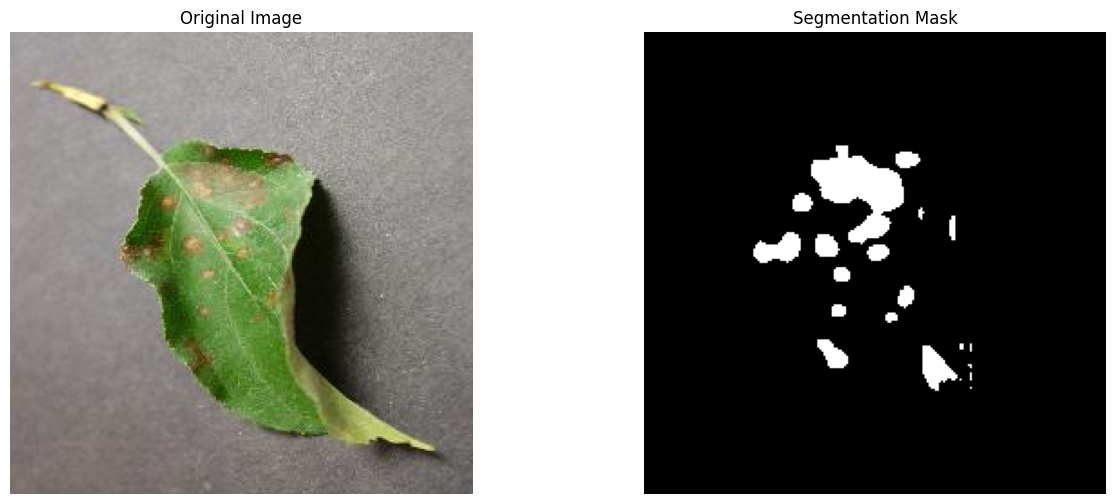

In [31]:
#scratch unet model
image_1_path = r"C:\Users\manup\Downloads\crop_dataset\test\test\AppleCedarRust3.JPG"
display_results(image_1_path, segmentation_model1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


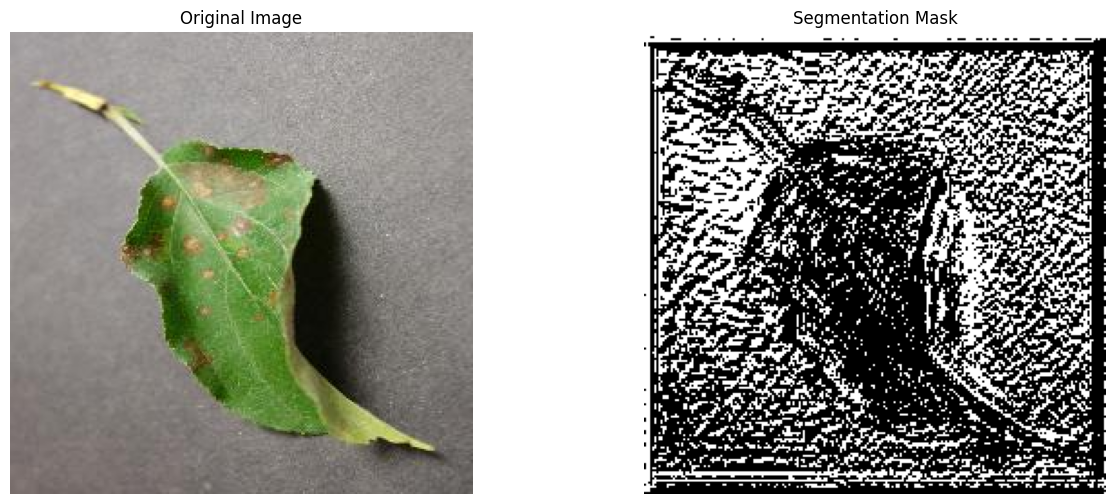

In [32]:
#inbuilt unet model 
image_1_path = r"C:\Users\manup\Downloads\crop_dataset\test\test\AppleCedarRust3.JPG"
display_results(image_1_path, segmentation_model2)

In [33]:

segmentation_model1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_36[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_38[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_43[0][0] 

 Total params: 520,673 (1.99 MB)

 Trainable params: 519,201 (1.98 MB)

 Non-trainable params: 1,472 (5.75 KB)

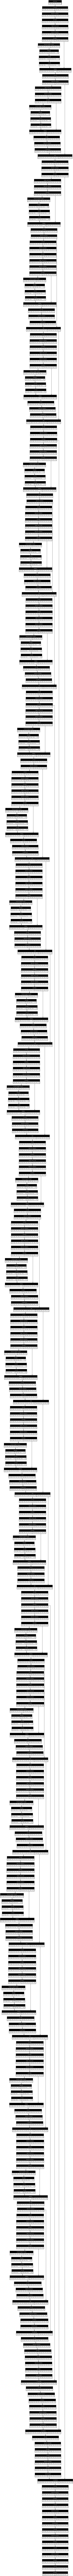

<Figure size 1000x800 with 0 Axes>

In [34]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Save to temporary file
plt.figure(figsize=(10,8))
plot_model(segmentation_model2, show_shapes=True)
# display(Image("temp_model.png"))
